In [16]:
import sys
import os
import numpy as np
import time
# Add the parent folder to sys.path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import density_generator
import numpy as np
import matplotlib.pyplot as plt
import qutip
import importlib
import helper_functions
import classicalQFI
import quantum_subroutines_pennylane
import pipeline_v200
import vqfe_subroutine
import pennylane as qml
import circuit_generator
from scipy.linalg import eigh
#from pennylane import numpy as np

from random import randint
importlib.reload(density_generator)
importlib.reload(helper_functions)
importlib.reload(quantum_subroutines_pennylane)
importlib.reload(vqfe_subroutine)
importlib.reload(pipeline_v200)
importlib.reload(circuit_generator)
importlib.reload(classicalQFI)

pass;

In [17]:
## parameters
N=5
n=3
#trace_out_indices= list(range(N - n))
trace_out_indices = np.sort(np.random.choice(range(N), size= N - n, replace=False))
#trace_out_indices = [0]
J=1
h_z=0.1
delta=0.5
m=1
# initial_state=None
DEBUG=False
derivative_delta=1e-3

print("N =",N, " starting number of qubits, before tracing out")
print("n =",n," final number of qubits")
print("trace_out_indices =",trace_out_indices)
print("J =",J)
print("h_z =",h_z)
print("delta =",delta)
print("m =",m)
print("DEBUG is set to: ",DEBUG)

N = 5  starting number of qubits, before tracing out
n = 3  final number of qubits
trace_out_indices = [1 4]
J = 1
h_z = 0.1
delta = 0.5
m = 1
DEBUG is set to:  False


In [18]:
trace_out_indices

array([1, 4])

In [19]:
# classical
print("TEST 1 : classical\n")
model = density_generator.SpinChainXXZ(n=N, J=J, h_z=h_z, initial_state="0", DEBUG=DEBUG) 
## using N because i will trace out

rho_pure, rho_delta_pure = model.generate_density_matrices_with_perturbation(delta=delta)
print("rho_pure shape = ", rho_pure.shape)
evals = np.linalg.eigvalsh(rho_pure)
entropy = -np.sum(evals * np.log2(evals + 1e-12))  # small epsilon for numerical stability
print("entanglement entropy = ", entropy)


rho_mixed, rho_delta_mixed = model.generate_mixed_density_matrices_with_perturbation(delta=delta,trace_out_indices=trace_out_indices)
print("rho_mixed shape = ", rho_mixed.shape)
print("purity of rho", np.trace(rho_mixed @ rho_mixed))
print("purity of rho_delta", np.trace(rho_delta_mixed @ rho_delta_mixed))

evals = np.linalg.eigvalsh(rho_mixed)
entropy = -np.sum(evals * np.log2(evals + 1e-12))  # small epsilon for numerical stability
print("entanglement entropy = ", entropy)

print("uhlmann fidelity = ", helper_functions.uhlmann_fidelity_root(rho_mixed, rho_delta_mixed))
print("fidelity pennylane = ",helper_functions.fidelity_pennylane(rho_mixed, rho_delta_mixed))


TEST 1 : classical

rho_pure shape =  (32, 32)
entanglement entropy =  -1.4469168956837894e-12
rho_mixed shape =  (8, 8)
purity of rho (0.3008229447455994+0j)
purity of rho_delta (0.3005458827413091+0j)
entanglement entropy =  1.8534407083566207
uhlmann fidelity =  0.8216650391820637
fidelity pennylane =  0.6751334461008661


TEST 2 : quantum

(<Figure size 3200x1100 with 1 Axes>, <Axes: >)


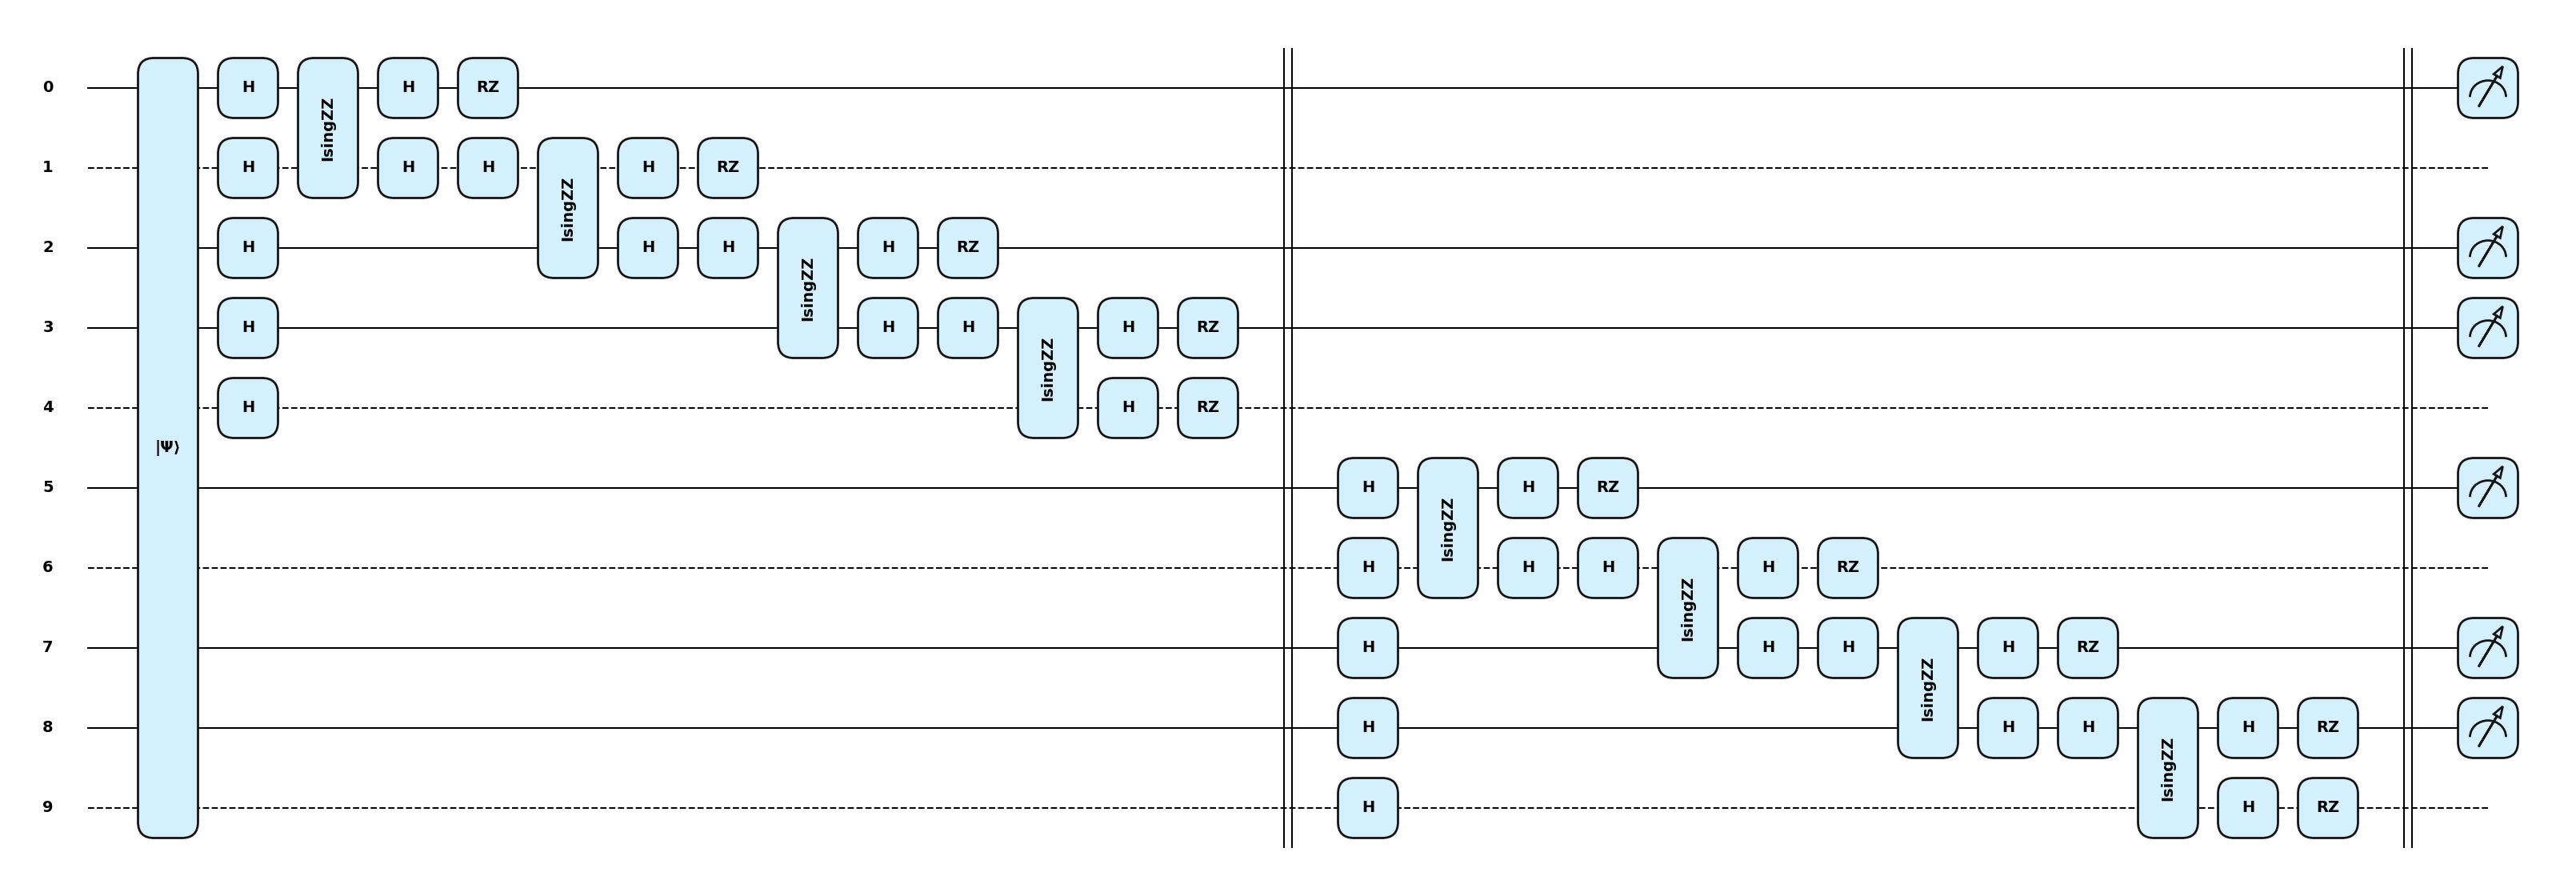

In [22]:
print("TEST 2 : quantum\n")

DRAW = True

import pennylane as qml
import pennylane.numpy as np

circuit_fn = circuit_generator.make_xx_plus_z_circuits(J, h_z, delta, N) 

# Attach to a device and QNode
dev = qml.device("default.qubit", wires=2 * N)

# trace out for the whole system composed by sys 1 and sys 2

active_rho = [x for x in list(range(N)) if x not in trace_out_indices] 
active_rho_delta = [x + N for x in active_rho]

measured_wires = active_rho + active_rho_delta
discarded_wires = [x for x in range(2*N) if x not in measured_wires]


@qml.qnode(dev)
def qnode():
    circuit_fn()
    #return qml.state()
    return qml.density_matrix(wires=measured_wires)


# --- Print the Circuit ---
wire_options = {
    #i: {'color': 'teal', 'linestyle': '--'} for i in discaded_wires # discarded wires
    i: {'linestyle': '--'} for i in discarded_wires # discarded wires
}

if DRAW:
    # Draw the circuit
    drawer = qml.draw_mpl(qnode, style="pennylane", wire_options=wire_options)
    #drawer = qml.draw(qnode)
    print(drawer())
 

In [23]:
vqfe_results = vqfe_subroutine.vqfe_from_circuit_disjoint(
    circuit_fn = circuit_fn,
    total_num_qubits=2*N,
    active_rho_wires = active_rho, 
    active_rho_delta_wires = active_rho_delta,
    L=2, 
    m=1, 
    maxiter=200)
vqfe_results


{'F_trunc': tensor(0.30399621, requires_grad=True),
 'F_star': tensor(0.9800803, requires_grad=True),
 'top_eigenvalues_rho': tensor([0.40983275], requires_grad=True),
 'trace_rho_m': tensor(0.40983275, requires_grad=True),
 'trace_sigma_m': 0.2254912345528774,
 'opt_params': array([[[ 1.18505308e+00, -5.90850918e-04,  9.25129127e-01],
         [ 7.31635920e-01, -8.74669874e-04, -9.28833390e-01],
         [-3.36181759e-01,  1.27218749e-03,  1.41067777e-01]],
 
        [[ 8.35814183e-01,  1.01293105e+00,  7.27970246e-02],
         [ 1.57271634e+00,  1.14595237e+00,  2.01794757e-01],
         [-1.29964934e-01,  6.90118175e-03,  8.95338602e-01]]]),
 'rho_rotated_final': array([[ 2.70525812e-01-3.19076892e-18j,  3.56685607e-04-4.74806583e-04j,
          1.93579531e-06+1.25096400e-05j,  7.64449107e-04+8.11600432e-04j,
         -1.24097070e-04+3.32761067e-05j, -2.69835539e-05+5.32239872e-05j,
         -1.42166793e-04+9.76589764e-05j, -7.72141656e-02+6.44816068e-03j],
        [ 3.56685607e-04

In [48]:
# collect fidelities

## parameters
N=4
n=3
trace_out_indices = np.random.choice(range(N), size= N - n, replace=False)
J=1
delta=0.5
m=2
# initial_state=None
DEBUG=False
derivative_delta=1e-3


# indices for quantum part
# trace out for the whole system composed by sys 1 and sys 2
active_rho = [x for x in list(range(N)) if x not in trace_out_indices] 
active_rho_delta = [x + N for x in active_rho]

measured_wires = active_rho + active_rho_delta
discarded_wires = [x for x in range(2*N) if x not in measured_wires]



results = []

for h_z in np.linspace(0, 2.5, 20):

    # classical fidelity
    # classical

    model = density_generator.SpinChainXXZ(n=N, J=J, h_z=h_z, initial_state="0", DEBUG=DEBUG) 
    
    rho_mixed, rho_delta_mixed = model.generate_mixed_density_matrices_with_perturbation(delta=delta,trace_out_indices=trace_out_indices)

    classical_results = classicalQFI.compute_tqfi_bounds(rho_mixed, rho_delta_mixed, m, delta, DEBUG=False)
    
    # quantum fidelity

    circuit_fn = circuit_generator.make_xx_plus_z_circuits(J, h_z, delta, N) 

    # Attach to a device and QNode
    dev = qml.device("default.qubit", wires=2 * N)
    vqfe_results = vqfe_subroutine.vqfe_from_circuit_disjoint(
        circuit_fn = circuit_fn,
        total_num_qubits=2*N,
        active_rho_wires = active_rho, 
        active_rho_delta_wires = active_rho_delta,
        L=2, 
        m=m, 
        maxiter= 256)

    results.append({
        "hz": h_z,
        "(Classical) uhlmann_fidelity": classical_results["uhlmann_fidelity"],
        "(Classical) pennylane_fidelity": classical_results["fidelity_pennylane"],
        "(Classical) fidelity_truncated":classical_results["fidelity_truncated"],
        "(Classical) fidelity_truncated_generalized": classical_results["fidelity_truncated_generalized"],
        "(Quantum) F_trunc" : vqfe_results["F_trunc"].item(),
        "(Quantum) F_star" : vqfe_results["F_star"].item(),

    })

    # quantum fidelity
    

df = pd.DataFrame(results)

    

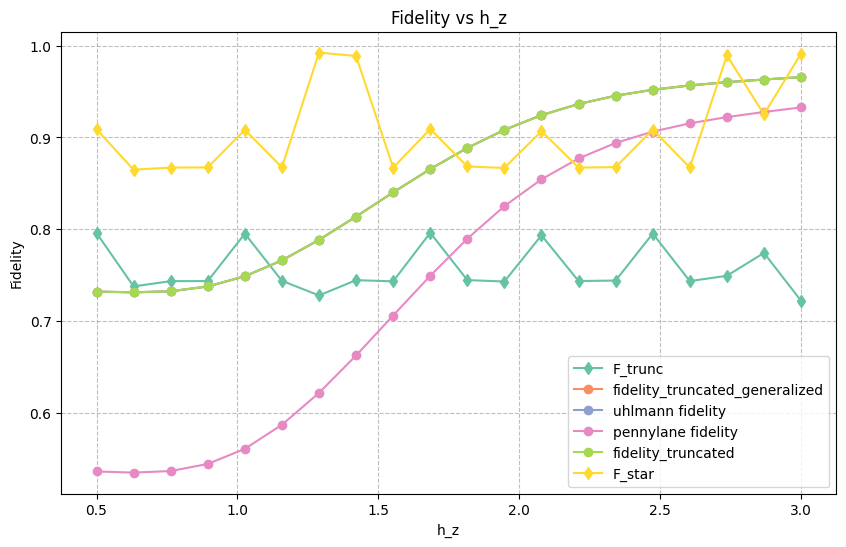

In [49]:
# plot fidelities
import seaborn as sns
sns.set_palette("Set2")
plt.figure(figsize=(10, 6))
plt.plot(df["hz"], df["(Quantum) F_trunc"], label="F_trunc", marker='d')
plt.plot(df["hz"], df["(Classical) fidelity_truncated_generalized"], label="fidelity_truncated_generalized", marker='o')
plt.plot(df["hz"], df["(Classical) uhlmann_fidelity"], label="uhlmann fidelity", marker='o')
plt.plot(df["hz"], df["(Classical) pennylane_fidelity"], label="pennylane fidelity", marker='o')
plt.plot(df["hz"], df["(Classical) fidelity_truncated"], label="fidelity_truncated", marker='o')
plt.plot(df["hz"], df["(Quantum) F_star"], label="F_star", marker='d')
plt.xlabel("h_z")
plt.ylabel("Fidelity")
plt.title("Fidelity vs h_z")
plt.legend()
# use a discomtinuous line style grid
plt.grid(
    linestyle='--',
    color='gray',
    alpha=0.5
)
plt.show()

In [83]:
def example_demo():
    """
    Demonstration: 
    We'll pick n_qubits=1 for simplicity, 
    define two small density matrices for rho, rho_delta, 
    measure sub/super fidelities, and compute 
    approximate QFI bounds for a small delta=0.1.
    """
    n_qubits = 1

    # Example: a pure state for rho
    psi = np.array([1.0, 0.0])
    rho = np.outer(psi, psi)

    # Another pure state for rho_delta
    phi = np.array([np.sqrt(0.7), np.sqrt(0.3)])
    rho_delta = np.outer(phi, phi)

    # Measure sub- and super-fidelity
    E_val, R_val = quantum_subroutines_pennylane.measure_sub_super_fidelity(n_qubits, rho, rho_delta)
    print("Subfidelity E(rho, rho_delta) =", E_val)
    print("Superfidelity R(rho, rho_delta) =", R_val)

    # Bounds on the standard fidelity: sqrt(E) <= F <= sqrt(R).
    F_lower = np.sqrt(E_val)
    F_upper = np.sqrt(R_val)
    print("Lower bound on fidelity =", F_lower)
    print("Upper bound on fidelity =", F_upper)

    # For small parameter shift delta, eq. (3) in the paper gives:
    #   I_delta(rho) = (8 / delta^2)*(1 - F(rho, rho_delta)).
    # So using the sub- and super-fidelity as bounds on F,
    # we get bounds on the QFI:
    delta = 0.1
    I_lower = (8.0 / delta**2)*(1.0 - F_upper)
    I_upper = (8.0 / delta**2)*(1.0 - F_lower)
    print("Approx. Lower bound on QFI =", I_lower)
    print("Approx. Upper bound on QFI =", I_upper)

example_demo()

Subfidelity E(rho, rho_delta) = 0.6999999999999995
Superfidelity R(rho, rho_delta) = 0.7000000000000002
Lower bound on fidelity = 0.8366600265340752
Upper bound on fidelity = 0.8366600265340757
Approx. Lower bound on QFI = 130.67197877273944
Approx. Upper bound on QFI = 130.6719787727398


In [84]:
n = 5 ## numero finale di qubit
N = 7 ## numero di qubit prima della traccia parziale

h_z_s = np.linspace(0, 5, num=20) # spazio dei valori di h_z

a_x= 3

delta = 0.5
derivative_delta = 1e-5
m = 7
DEBUG=True
initial_state = helper_functions.random_mixed_density_matrix(N, n)

# ket = qutip.rand_ket(2**n, distribution="haar").full().flatten()

y_s = np.array([pipeline_v200.simulation(
                        N=N,
                        n=n,
                        initial_state= initial_state,
                        DEBUG=True,
                        derivative_delta=derivative_delta,
                        a_x= a_x, 
                        h_z= h_z, ## variable
                        delta = delta,
                        m = m) for h_z in h_z_s])

# just for plotting clarity
sparse_indices = np.array([i for i in list(range(len(h_z_s))) if i%10==0])

Generating random mixed density matrix
purity of initial state = (0.2797908366388472-2.2768245622195593e-18j) 


AttributeError: module 'density_generator' has no attribute 'IsingQuantumState'

In [85]:
import density_generator

# from qiskit.visualization import plot_state_city
from importlib import reload
import pandas as pd
import numpy as np
import classicalQFI
import qutip
import helper_functions

reload(helper_functions)
reload(density_generator)
reload(classicalQFI)



def simulation(
    N=10,
    n=7,
    a_x=1,
    h_z=0.1,
    delta=0.01,
    m=1,
    initial_state=None,
    DEBUG=False,
    derivative_delta=1e-3,
):
    """ "
    Simulate the quantum state evolution and compute the QFI bounds.
    params:
    N: number of qubits
    n: ending number of qubits (we will trace out N - n qubits)
    a_x: coupling coefficient for the Ising interaction term
    h_z: perturbation strength
    delta: "error" state difference
    m: number of largest eigenvalues to keep
    initial_state: initial state of the system (matrix or state vector)
    DEBUG: print debug information
    derivative_delta: step size for SLD
    """

    if initial_state is None:
        if DEBUG:
            print("Generating random initial state")
        # Generate random initial state
        ket = helper_functions.random_haar_ket(2**N)

        rho = np.outer(ket, np.conj(ket))

        trace_out_index = np.random.choice(range(N), size=N - n, replace=False)

        v = helper_functions.trace_out(rho=rho, trace_out_index=trace_out_index)
    else:
        v = initial_state

    if DEBUG:
        purity = np.trace(v @ v)
        print(f"purity of initial state = {purity} ")

    # Generate new density matrix using Ising model
    model = density_generator.IsingQuantumState(
        n=n, a_x=a_x, h_z=h_z, initial_state=v, DEBUG=DEBUG
    )
    rho = model.generate_density_matrix()

    if DEBUG:
        # Calculate purity and participation ratio
        purity = np.trace(rho @ rho)
        participation_ratio = 1 / purity
        print(f"Purity of evolved state: {purity}")
        print(f"Participation ratio: {participation_ratio}")

    ####### END) generation of the matrices

    rho, rho_delta = model.generate_density_matrices_with_perturbation(delta=delta)

    ## Getting results from classical QFI
    results = classicalQFI.compute_tqfi_bounds(
        rho=rho, rho_delta=rho_delta, m=m, delta=delta
    )

    if derivative_delta is None:
        derivative_delta = (delta / 100,)

    # this method is not parameter agnostic, so it is not into classicalQFI
    qfi_from_SLD = model.compute_qfi_with_sld(delta=delta, d=derivative_delta)

    # append the true QFI to the results, taken using the pure states,
    # before the partial trace (this idea was not good)

    ## Optional overlap with |00...00>
    # ket_0n = np.zeros(n-1, dtype=complex)
    # ket_0n[0] = 1.0
    # ket_0n = ket_0n.transpose()
    # overlap = ket_0n @

    if DEBUG:  ## check trace of rho
        # print(f"trace of rho: {np.trace(rho)}")
        # print(f"trace of rho + delta: {np.trace(rho_delta)}")
        ## check also purity
        # print(f"purity of rho: {np.trace(rho @ rho)}")
        # print(f"purity of rho + delta: {np.trace(rho_delta @ rho_delta)}")
        ## check also rank
        # print(f"rank of rho: {np.linalg.matrix_rank(rho)}")
        # print(f"rank of rho + delta: {np.linalg.matrix_rank(rho_delta)}")
        # put all of the above in a dictionary
        results["trace_rho"] = np.trace(rho)
        results["trace_rho_delta"] = np.trace(rho_delta)
        results["purity_rho"] = np.trace(rho @ rho)
        results["purity_rho_delta"] = np.trace(rho_delta @ rho_delta)
        results["rank_rho"] = np.linalg.matrix_rank(rho)
        results["rank_rho_delta"] = np.linalg.matrix_rank(rho_delta)

        results["truncated_eigenvalues"] = (
            helper_functions.get_truncated_eigen_decomposition(rho=rho, m=m)[0]
        )
        results["eigenvalues"] = helper_functions.compute_eigen_decomposition(rho=rho)[
            0
        ]

    results["QFI_from_SLD"] = qfi_from_SLD

    return results
